In [ ]:
# !pip install konlpy
# !pip install matplotlib
# !pip install streamlit
# !pip install tensorflow==2.13.0

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import matplotlib.pyplot as plt
import re
import json
from konlpy.tag import Okt


In [ ]:
DATA_IN_PATH = '/content/drive/MyDrive/Chatbot_data-master/data_in/'
DATA_OUT_PATH ='/content/drive/MyDrive/Chatbot_data-master/data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))


# index_inputs = np.load(open())

In [ ]:
idx = 5

print(index_inputs[idx])
print(index_outputs[idx])
print(index_targets[idx])

[51 67 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
[  1  42  83  23 109   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[ 42  83  23 109   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


In [ ]:
tf.random.set_seed(1)

# 모델 변수값
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 20
# GRU(RNN) hidden dim
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_idx = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

print(char2idx)
print(idx2char)
print(std_index)
print(end_idx)
print(vocab_size)

{'<PAD>': 0, '<SOS>': 1, '<END>': 2, '<UNK>': 3, '뭐가': 4, '운동을': 5, '갔어': 6, '켜고': 7, '그럴': 8, '남자친구가': 9, '나왔다': 10, '같아요': 11, '해': 12, '나온거': 13, '안': 14, '것': 15, '구하셨나요': 16, '비싼데': 17, '가만': 18, '마세요': 19, '감기': 20, '결단은': 21, '거짓말': 22, '새출발': 23, '망함': 24, '데려가고': 25, '따뜻하게': 26, '즐기세요': 27, '뭘': 28, '집에': 29, '남자친구': 30, '좋다': 31, '혼자를': 32, '들어올': 33, '필요한': 34, '나라를': 35, '선물로': 36, '잘생겼어': 37, '땀난다': 38, '게': 39, '혼자인게': 40, '뭐하는지': 41, '어서': 42, '보인다': 43, '거예요': 44, '더': 45, '사세요': 46, '나갔어': 47, '승진': 48, '또': 49, '마음을': 50, '가상화폐': 51, '오늘': 52, '그': 53, '땀을': 54, '자의': 55, '줄까': 56, '같아': 57, '나오세요': 58, '싶어': 59, '운동만': 60, '좋을': 61, '절약해봐요': 62, '빠를수록': 63, '좋아요': 64, '나': 65, '교회': 66, '쫄딱': 67, '끄고': 68, '가스비': 69, '많이': 70, '사람도': 71, '평소에': 72, '해보세요': 73, '있어도': 74, '걸리겠어': 75, '생각해보세요': 76, '궁금해': 77, '집착하지': 78, '훈훈해': 79, '운동': 80, '좀': 81, '너무': 82, '잊고': 83, '설득해보세요': 84, '질린다': 85, '다시': 86, '함께': 87, '돌아가서': 88, '바빠': 89, '가난한': 90, '켜놓고': 91, '좋을까?': 92,

## **Encoder 만들기**

In [ ]:
class Encoder(keras.layers.Layer):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_size = batch_sz
    self.enc_units = enc_units
    self.vocab_size = vocab_size
    self.embedding = embedding_dim
    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(enc_units, return_sequences=True,
                                return_state=True,
                                recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    _, state = self.gru(x, initial_state=hidden)

    return state

  def initialize_hidden_state(self, inp):
    return tf.zeros((tf.shape(inp)[0], self.enc_units))

## **Decoder 만들기**



In [ ]:
class Decoder(keras.layers.Layer):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_size = batch_sz
    self.enc_units = dec_units
    self.vocab_size = vocab_size
    self.embedding = embedding_dim
    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(dec_units, return_sequences=True,
                                return_state=True,
                                recurrent_initializer='glorot_uniform')
    self.fc = keras.layers.Dense(self.vocab_size, activation = 'softmax')


  def call(self, x, dec_hidden):
    x = self.embedding(x)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, state, output

In [ ]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')

# zero padding 해준 결과 0으로 처리된 값을 계산하지 않도록 하는 함수

def loss(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)


# **seq2seq 모델**

In [ ]:
class seq2seq(keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx = 2):
    super(seq2seq, self).__init__()
    self.end_token_idx = end_token_idx
    self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
    self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)


  def call(self, x):
    # index_inputs, index_outputs
    inp, tar = x
    end_hidden = self.encoder.initialize_hidden_state(inp)
    enc_hidden = self.encoder(inp, end_hidden)
    dec_hidden = enc_hidden

    predict_tokens = []
    for t in range(0, tar.shape[1]):
      dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t],1), tf.float32)
      predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden)
      predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))

    predicted = tf.stack(predict_tokens, axis=1)

    return predicted

  def inference(self, x):
    inp = x

    enc_hidden_init = self.encoder.initialize_hidden_state(inp)
    enc_hidden = self.encoder(inp, enc_hidden_init)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([char2idx[std_index]], 1)

    predict_tokens = []
    for i in range(0, MAX_SEQUENCE):
      predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden)
      predict_token = tf.argmax(predictions[0])
      if predict_token == self.end_token_idx:
        break

      predict_tokens.append(predict_token)
      dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

    return tf.stack(predict_tokens, axis=0).numpy()


In [ ]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, 2)
model.compile(loss = loss, optimizer = keras.optimizers.Adam(1e-3))

In [ ]:
PATH = DATA_OUT_PATH + MODEL_NAME
PATH

'/content/drive/MyDrive/Chatbot_data-master/data_out/seq2seq_kor'

In [ ]:
if not(os.path.isdir(PATH)):
  os.makedirs(os.path.join(PATH))

checkpoint_path = PATH + '/weight.h5'

cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              monitor = 'val_loss', verbose = 1,
                                              save_best_only=True,
                                              save_weights_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01,
                                            patience=5)
history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs = EPOCH,
                    validation_split = VALIDATION_SPLIT,
                    callbacks = [cp_callback, es_callback])

Epoch 1/20


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x79e585017cd0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x79e585017cd0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


9/9 [==============================] - ETA: 0s - loss: 0.8686

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from inf to 0.75344, saving model to /content/drive/MyDrive/Chatbot_data-master/data_out/seq2seq_kor/weight.h5
9/9 [==============================] - 66s 3s/step - loss: 0.8686 - val_loss: 0.7534
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 0.8685
Epoch 2: val_loss improved from 0.75344 to 0.75329, saving model to /content/drive/MyDrive/Chatbot_data-master/data_out/seq2seq_kor/weight.h5
9/9 [==============================] - 10s 1s/step - loss: 0.8685 - val_loss: 0.7533
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 0.8682
Epoch 3: val_loss improved from 0.75329 to 0.75295, saving m

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+ string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.ylim(0, 1)
    plt.legend([string, 'val_'+string])
    plt.show()

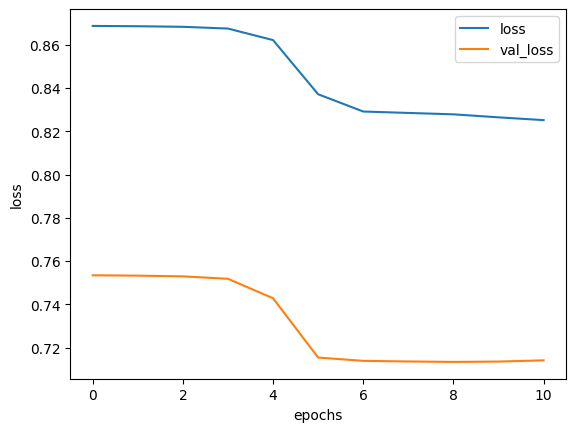

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
SAVE_FILE_NM = "weight.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [ ]:
# !pip install tqdm

In [ ]:
from tqdm import tqdm

FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS)


PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"


def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []
    sequences_length = []

    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)

        sequence_index = []
        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])

        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]

        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index), sequences_length

In [ ]:
# query = "남자친구 승진 선물로 뭐가 좋을까?"

query = "남자친구가 너무 바빠"


test_index_inputs, _ = enc_processing([query], char2idx)
print(test_index_inputs)

predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[[ 9 82 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
[105]
빨리
